In [1]:
# Librerías

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization, Concatenate, Conv2DTranspose, ZeroPadding2D, Activation, MaxPool2D
from keras.regularizers import l2,l1,L1L2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.metrics import Precision, SensitivityAtSpecificity, Accuracy
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import random

In [2]:
path = "/kaggle/input/fetus-segmentation/"

dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)

path_preprocessed_images = path + 'preprocessed_images/'
path_segmentations = path + 'segmentations/'

Files and directories in ' /kaggle/input/fetus-segmentation/ ' :
['preprocessed_images', 'segmentations']


# Lectura y preprocesamiento de datos

In [3]:
list_paths_preprocessed_images = [path_preprocessed_images+file for file in os.listdir(path_preprocessed_images)]
list_paths_segmentations = [path_segmentations+file for file in os.listdir(path_segmentations)]

list_paths_preprocessed_images.sort()
list_paths_segmentations.sort()

In [4]:
print(list_paths_preprocessed_images[:4])
print(list_paths_segmentations[:4])

['/kaggle/input/fetus-segmentation/preprocessed_images/0.png', '/kaggle/input/fetus-segmentation/preprocessed_images/1.png', '/kaggle/input/fetus-segmentation/preprocessed_images/10.png', '/kaggle/input/fetus-segmentation/preprocessed_images/100.png']
['/kaggle/input/fetus-segmentation/segmentations/seg_0.png', '/kaggle/input/fetus-segmentation/segmentations/seg_1.png', '/kaggle/input/fetus-segmentation/segmentations/seg_10.png', '/kaggle/input/fetus-segmentation/segmentations/seg_100.png']


In [5]:
images = np.float32(np.array([cv2.resize(cv2.imread(path,cv2.COLOR_GRAY2RGB), (300, 225))/255.0 for path in list_paths_preprocessed_images]))

segmentations = np.array([cv2.resize(cv2.imread(path), (300, 225))[:,:,0]/255.0 for path in list_paths_segmentations])

(1110, 225, 300, 1)


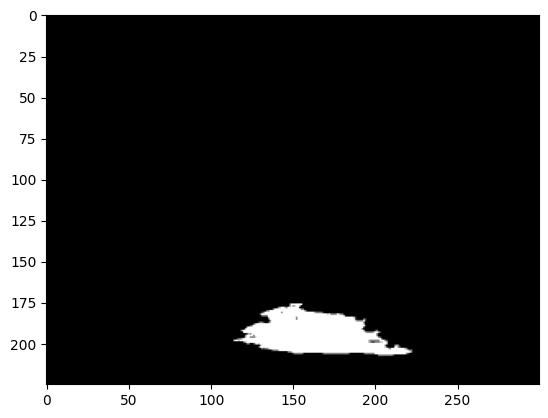

In [6]:
def new_dim(img):
    segs = np.empty((225,300,1))
    segs[:,:,0] = img
    return segs

segmentations_2 = np.array([new_dim(img) for img in segmentations])
print(np.shape(segmentations_2))

plt.imshow(segmentations_2[0],cmap='gray')
plt.show()

In [7]:
def binarization(img):
    new_img = img.copy()
    new_img[img >= 0.5] = 1
    new_img[img < 0.5] = 0

    return new_img

segmentations_prepro = np.uint8(np.array([binarization(img) for img in segmentations_2]))

In [8]:
print('Dimensiones de "images": ',np.shape(images))
print('Dimensiones de "segmentations_prepro": ',np.shape(segmentations_prepro))

Dimensiones de "images":  (1110, 225, 300, 3)
Dimensiones de "segmentations_prepro":  (1110, 225, 300, 1)


In [9]:
print('Valores mínimos y máximo de "images[0]": ', np.min(images[0]), np.max(images[0]))
print('Valores únicos de "segmentations_prepro[0]": ', np.unique(segmentations_prepro[0]))

Valores mínimos y máximo de "images[0]":  0.003921569 0.84705883
Valores únicos de "segmentations_prepro[0]":  [0 1]


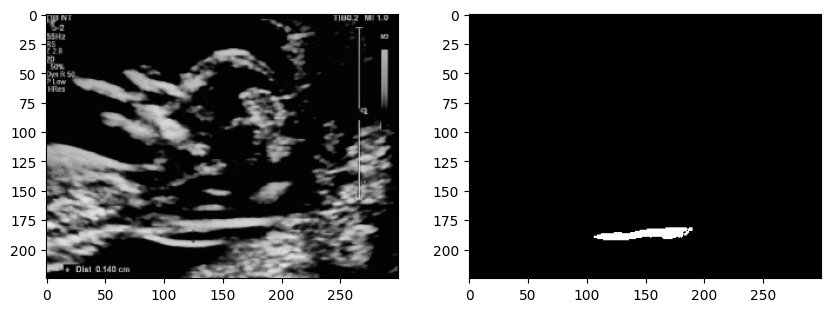

In [10]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,2,1)
ax.imshow(images[12],cmap='gray')

ax = fig.add_subplot(1,2,2)
ax.imshow(segmentations_prepro[12],cmap='gray')

plt.show()

In [27]:
def segmentationDemo(img,segmentation):

    img_color = img.copy()
    
    indexes2 = np.argwhere(segmentation==1)
    
    img_color[:,:,0][indexes2[:,0],indexes2[:,1]] = 0
    img_color[:,:,1][indexes2[:,0],indexes2[:,1]] = 255
    img_color[:,:,2][indexes2[:,0],indexes2[:,1]] = 255
    
    return img_color

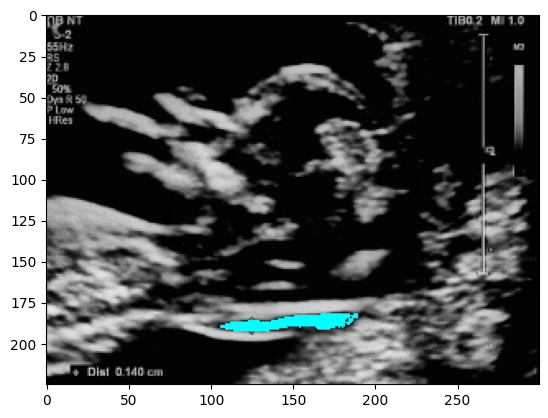

In [28]:
img_demo = segmentationDemo(images[12],segmentations_prepro[12])

plt.imshow(img_demo)
plt.show()

# Split de datos

In [11]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, segmentations_prepro, test_size=0.1)

# Example: Display the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (999, 225, 300, 3)
X_val shape: (111, 225, 300, 3)
y_train shape: (999, 225, 300, 1)
y_val shape: (111, 225, 300, 1)


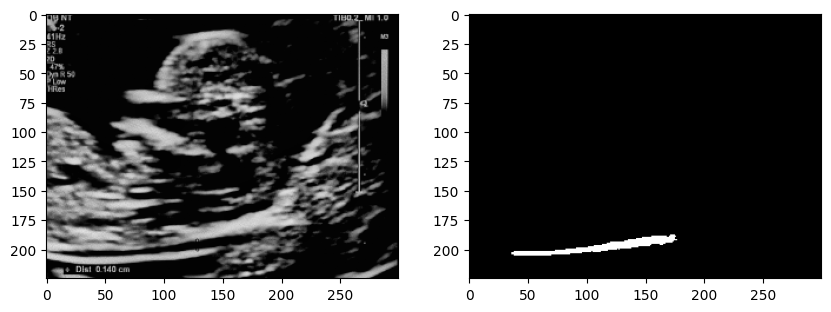

In [12]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,2,1)
ax.imshow(X_train[3],cmap='gray')

ax = fig.add_subplot(1,2,2)
ax.imshow(y_train[3],cmap='gray')

plt.show()

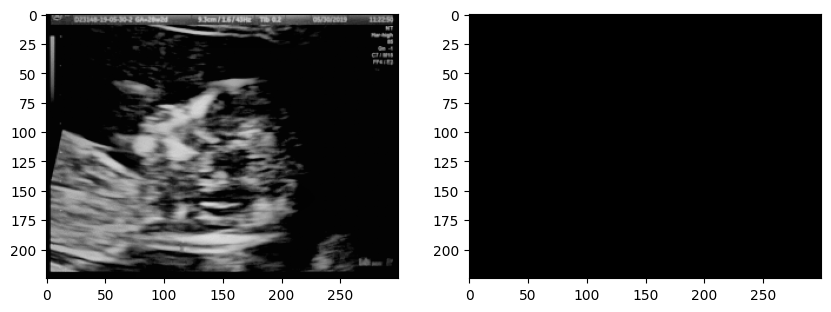

In [13]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,2,1)
ax.imshow(X_val[12],cmap='gray')

ax = fig.add_subplot(1,2,2)
ax.imshow(y_val[12],cmap='gray')

plt.show()

In [14]:
print(X_train[0].dtype, np.shape(X_train[0]))
print(X_val[0].dtype, np.shape(X_val[0]))
print(y_train[0].dtype, np.shape(y_train[0]), np.unique(y_train[0]))
print(y_val[0].dtype, np.shape(y_val[0]), np.unique(y_val[0]))

float32 (225, 300, 3)
float32 (225, 300, 3)
uint8 (225, 300, 1) [0 1]
uint8 (225, 300, 1) [0 1]


# Modelo

In [15]:
# Sensibilidad (Recall)
def sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    return true_positives / (possible_positives + K.epsilon())

# Especificidad
def specificity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_negatives = K.sum((1 - y_true) * (1 - y_pred))
    possible_negatives = K.sum(1 - y_true)
    return true_negatives / (possible_negatives + K.epsilon())

In [16]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.75, 
                              patience=8, 
                              min_lr=1e-6, 
                              verbose=1)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True)

In [17]:
def encoder_block(inputs, num_filters): 
    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(inputs) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Max Pooling with 2x2 filter
    p = MaxPool2D(pool_size=(2, 2))(x) 
    return x, p

def decoder_block(inputs, skip_features, num_filters): 
    # Upsampling with 2x2 filter
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs) 

    # Ensure the shapes match by cropping or padding
    if x.shape[1] != skip_features.shape[1] or x.shape[2] != skip_features.shape[2]:
        x = ZeroPadding2D(((0, skip_features.shape[1] - x.shape[1]), (0, skip_features.shape[2] - x.shape[2])))(x)

    # Concatenate skip connections
    x = Concatenate()([x, skip_features]) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 

    # Convolution with 3x3 filter followed by ReLU activation
    x = Conv2D(num_filters, 3, padding='same')(x) 
    x = Activation('relu')(x) 
    return x

def unet_model(input_shape=(100, 100, 3), num_classes=1): 
    inputs = Input(input_shape) 
    
    # Contracting Path
    s1, p1 = encoder_block(inputs, 64) 
    s2, p2 = encoder_block(p1, 128) 
    s3, p3 = encoder_block(p2, 256) 
    s4, p4 = encoder_block(p3, 512) 
    
    # Bottleneck
    b1 = Conv2D(1024, 3, padding='same')(p4) 
    b1 = Activation('relu')(b1) 
    b1 = Conv2D(1024, 3, padding='same')(b1) 
    b1 = Activation('relu')(b1) 
    
    # Expansive Path
    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block(d1, s3, 256) 
    d3 = decoder_block(d2, s2, 128) 
    d4 = decoder_block(d3, s1, 64) 
    
    # Output Layer
    outputs = Conv2D(num_classes, 1, activation='sigmoid' if num_classes == 1 else 'softmax')(d4) 
    
    model = Model(inputs, outputs, name='U-Net') 
    return model

In [18]:
learning_rate = 0.001

from tensorflow import distribute
strategy = distribute.MirroredStrategy()

with strategy.scope():
    # instantiate your model here
    learning_rate = 0.001
    optimizer = Adam(learning_rate=learning_rate)
    model =  unet_model(input_shape=(225, 300, 3), num_classes=1)

model.compile(optimizer= optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 225, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 225, 300,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 225, 300,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 225, 300,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 225, 300,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 150,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 150,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 150,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 150,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 150,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 75,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 75,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 75,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 75,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 56, 75,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 37,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 37,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    x = X_train,
    y = y_train,
    validation_data = (X_val,y_val),
    batch_size = 32,
    epochs = 20,
    callbacks = [reduce_lr, early_stopping]
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8705 - loss: 0.5850 - val_accuracy: 0.9917 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 891ms/step - accuracy: 0.9919 - loss: 0.0506 - val_accuracy: 0.9917 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 946ms/step - accuracy: 0.9918 - loss: 0.0361 - val_accuracy: 0.9917 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 980ms/step - accuracy: 0.9914 - loss: 0.0323 - val_accuracy: 0.9917 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 932ms/step - accuracy: 0.9918 - loss: 0.0263 - val_accuracy: 0.9917 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 963ms/step - accuracy: 0.9917 - loss: 0.0229 - val_accuracy: 0.9944 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 972ms/step - accuracy: 0.9934 - loss: 0.017

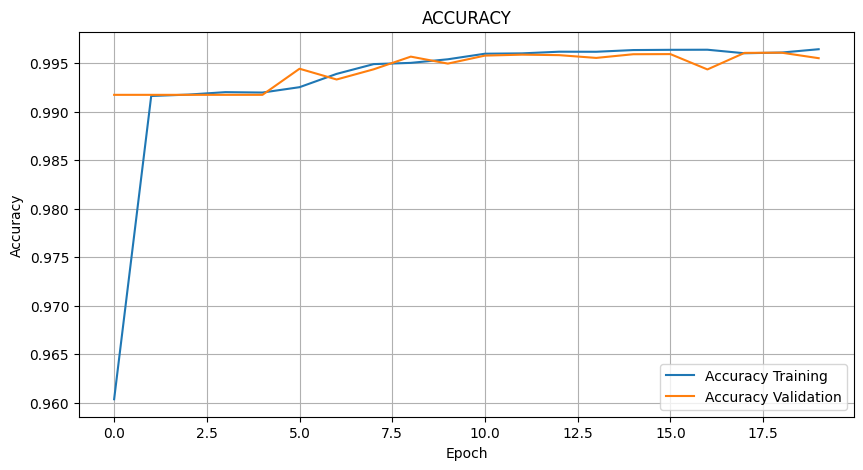

In [44]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.plot(history.history['accuracy'],label='Accuracy Training')
ax.plot(history.history['val_accuracy'],label='Accuracy Validation')
ax.set_title('ACCURACY')
ax.legend(loc='lower right')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


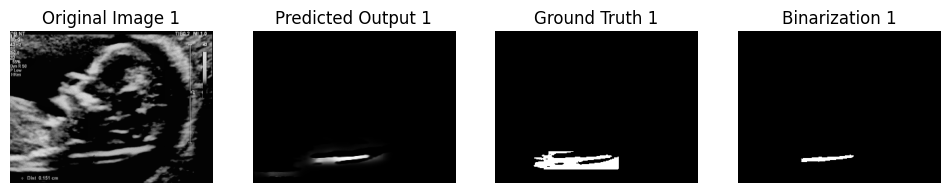

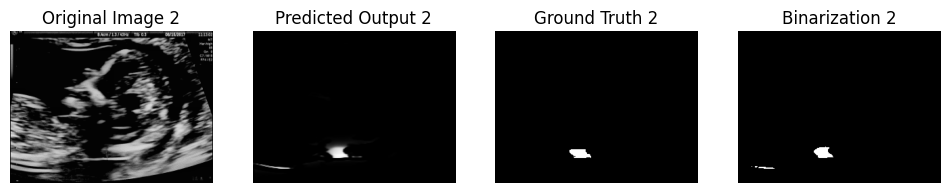

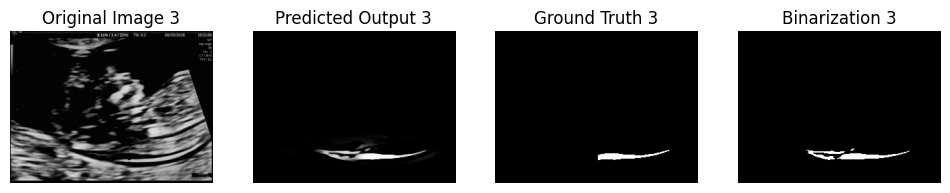

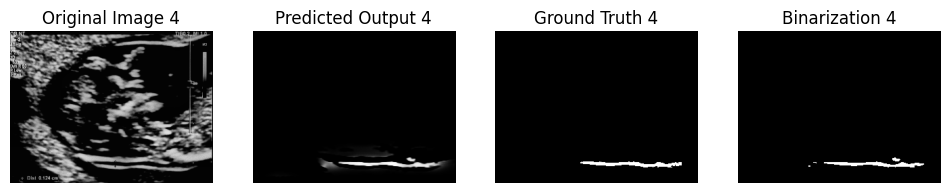

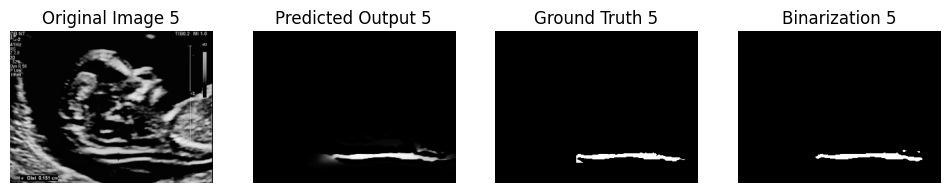

In [29]:
y_pred = model.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 4))

    # Original image (input image to the model)
    plt.subplot(1, 4, 1)
    plt.imshow(X_val[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    # Predicted output (the model's output)
    plt.subplot(1, 4, 2)
    plt.imshow(y_pred[i], cmap='gray')  # Use grayscale for segmentation maps
    plt.title(f"Predicted Output {i+1}")
    plt.axis('off')

    # Validation image (ground truth mask)
    plt.subplot(1, 4, 3)
    plt.imshow(y_val[i], cmap='gray')
    plt.title(f"Ground Truth {i+1}")
    plt.axis('off')

    # Binarization of the output image
    y_bin = y_pred[i] > 0.5
    plt.subplot(1, 4, 4)
    plt.imshow(y_bin, cmap='gray')
    plt.title(f"Binarization {i+1}")
    plt.axis('off')

    # Display the plot
    plt.show()

In [34]:
def getBinarization(img_predicha,alpha=0.5):
    img = img_predicha.copy()
    img[img_predicha >= alpha] = 1
    img[img_predicha < alpha] = 0

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


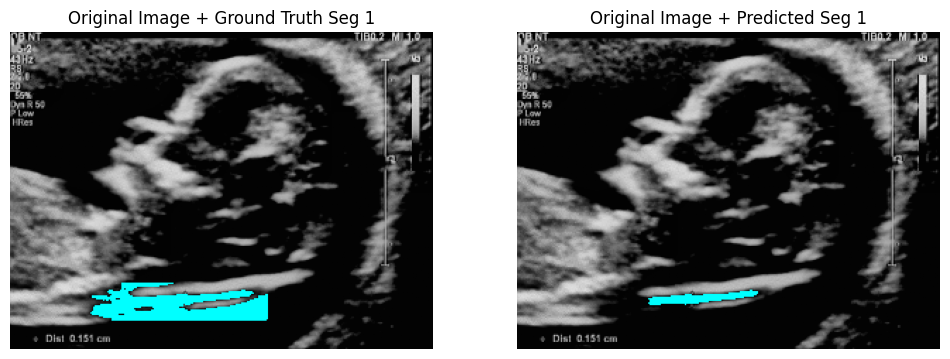

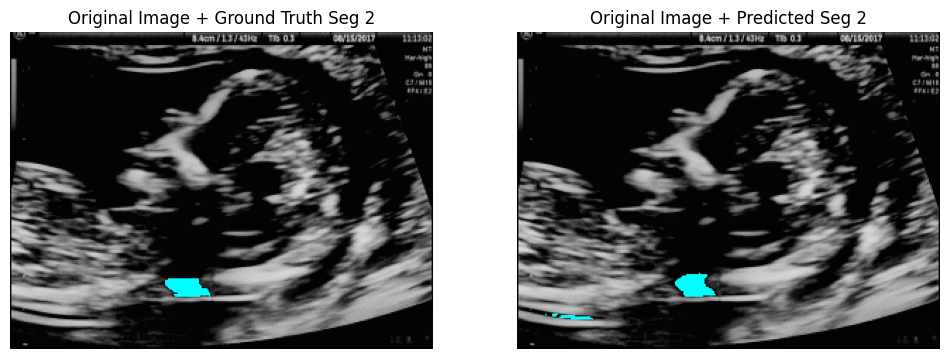

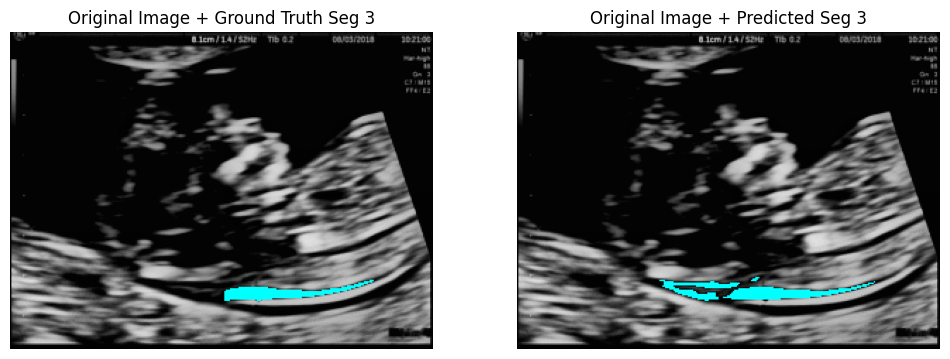

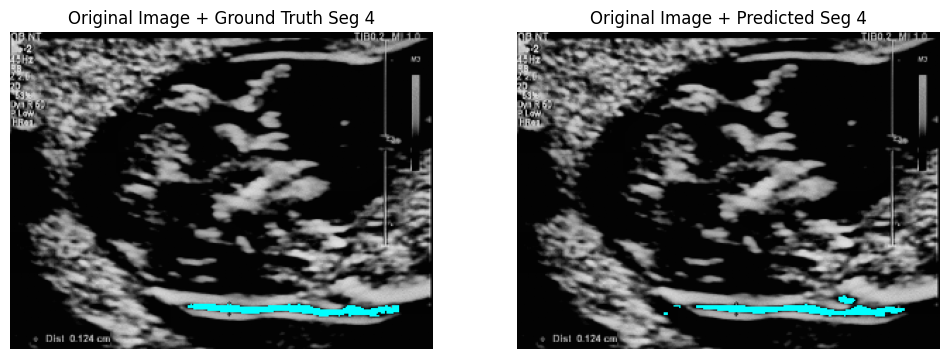

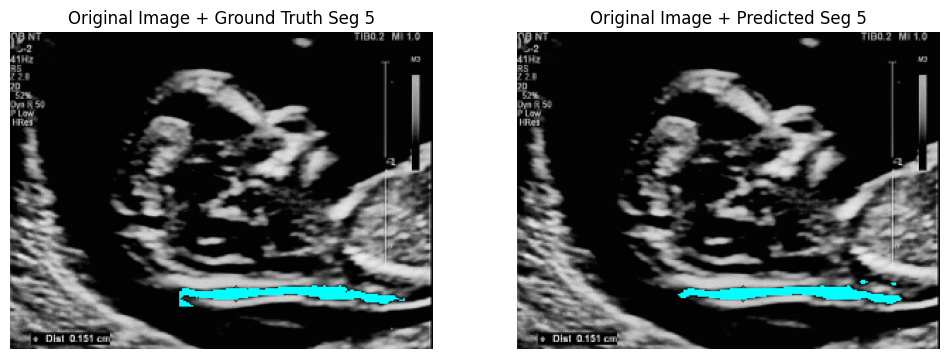

In [35]:
y_pred = model.predict(X_val[:5])  # Predict on the first 5 validation images

# Create a plot to compare original, predicted, and validation images
for i in range(5):  # Show the first 5 images
    plt.figure(figsize=(12, 7))

    truth_seg_plus_image = segmentationDemo(X_val[i],y_val[i])

    predicted_segmentation = getBinarization(y_pred[i])

    pred_seg_plus_image = segmentationDemo(X_val[i],predicted_segmentation)
    
    plt.subplot(1, 2, 1)
    plt.imshow(truth_seg_plus_image)
    plt.title(f"Original Image + Ground Truth Seg {i+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_seg_plus_image)
    plt.title(f"Original Image + Predicted Seg {i+1}")
    plt.axis('off')
    
    # Display the plot
    plt.show()

In [36]:
model.save_weights('model-unet.weights.h5')
model.save('model-unet-model.keras')